In [ ]:
# This notebook has been adapted from 'Covariance_BoxGeometry.ipynb' to compute
# results for matter power spectrum covariance instead of galaxies

# Computes non-linear Gaussian covariance + tree-level trispectrum

# Cells where inputs should be specified are labelled as #INPUT

In [1]:
import scipy, time, sys
from scipy.fftpack import fft2, fftn, ifftn
from scipy.special import hyp2f1
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import quad, tplquad
from scipy.misc import derivative
import numpy as np
from numpy import exp, log, log10, cos, sin, pi, cosh, sinh , sqrt, amin, amax, mean
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.insert(0, '/Users/jayw/Dropbox/Drop_Acad/Roman/Covariance/Public_CovaPT/detail')
import T0

In [2]:
# Aesthetic definitions for the plots
font = {'size'   : 14, 'family':'STIXGeneral'}
matplotlib.rc('font', **font)
matplotlib.rc('axes', labelsize=18) 
matplotlib.mathtext.rcParams['legend.fontsize']=16
plt.rcParams["figure.figsize"] = [6.0,4.]

#matplotlib.rc('font',**{'family':'serif','serif':['Palatino']})
matplotlib.rc('text', usetex=True)

In [3]:
# If you want to use my input files in this code, please download them from below and set the directory location:
# https://drive.google.com/drive/folders/1bWKfUaIXcC1n-2hk9KtKhqukxTH1379i?usp=sharing

dire='/Users/jayw/Dropbox/Drop_Acad/Roman/Covariance/data/Public/'

In [4]:
#INPUT

# array of k-values
dk=0.005 #Bin width
k=np.arange(0.005,0.25,dk); #k contains the bin centers
kbins=len(k) #number of k-bins

Lbox = 650 #Mpc/h
vol = Lbox**3 #Volume of box/survey

#inbar = Lbox**3/158262. #Inverse of galaxy number density
inbar=0;

Nmodes = vol/3/(2*pi**2)*( (k+dk/2)**3-(k-dk/2)**3) #Number of k-modes in shells

In [5]:
# Growth factor and growth rate for LCDM case
def Dz(z,Om0):
    return(scipy.special.hyp2f1(1/3., 1, 11/6., (1-1/Om0)/(1+z)**3)
                                /scipy.special.hyp2f1(1/3., 1, 11/6., 1-1/Om0)/(1+z))

def fgrowth(z,Om0):
    return(1. + 6*(Om0-1)*scipy.special.hyp2f1(4/3., 2, 17/6., (1-1/Om0)/(1+z)**3)
                  /( 11*Om0*(1+z)**3*scipy.special.hyp2f1(1/3., 1, 11/6., (1-1/Om0)/(1+z)**3) ))

In [6]:
#INPUT

# Enter Omega_m and z values
Om = 0.307115
z = 0.

# Enter bias parameter values

b1 = 1; #Linear bias
be = 0; #beta = f/b1, zero for real space


#All non-linear and non-local parameters are zero for matter case
g2 = 0
g3 = 0;
b2 = 0 
g2x = 0;
g21 = 0;
b3 = 0

#Initializing the trispectrum code with the bias params
T0.InitParameters([b1,be,g2,b2,g3,g2x,g21,b3])

In [7]:
#INPUT

# Linear power spectrum from Class or CAMB
# Note that Plin used in code has factors of b1 and Dz
pdata=np.loadtxt(dire+'Pk_lin_CAMB.dat')
Plin=InterpolatedUnivariateSpline(pdata[:,0], Dz(z, Om)**2*b1**2*pdata[:,1])

Text(0, 0.5, '$b_1^2\\ D(z)^2\\ P_\\mathrm{lin}(k)$')

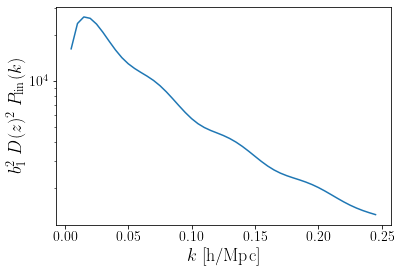

In [8]:
plt.semilogy(k,Plin(k))
plt.xlabel(r"$k$  [h/Mpc]"); plt.ylabel(r"$b_1^2\ D(z)^2\ P_\mathrm{lin}(k)$")

# Real Space

In [9]:
#Best-fit theory power fitted to survey data (currently used same as Plin)

#Pfit=InterpolatedUnivariateSpline(pdata[:,0], pdata[:,1])
Pfit= lambda k: Plin(k)

In [10]:
CovGaussian=4/3.*(Pfit(k) + inbar)**2/Nmodes

Text(0, 0.5, '$[C_\\mathrm{Gauss}(k,k)/P(k)^2]^{1/2}$')

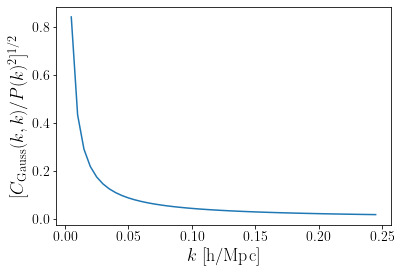

In [11]:
#Plotting diagonal elements of the Gaussian covariance matrix
plt.plot(k,np.sqrt(CovGaussian/(Plin(k)**2)))
plt.xlabel(r"$k$  [h/Mpc]"); plt.ylabel(r"$[C_\mathrm{Gauss}(k,k)/P(k)^2]^{1/2}$")

In [12]:
# Now calculating terms for the regular trispectrum (tree-level) part

# Let us first focus on the trispectrum terms, the expressions below are taken from 
# the mathematica notebook (Generating_T0_Z12_expressions.nb)
# which shows their derivation

# First Z1 Z1 Z2 shot noise term in Eq. 91
def e34o44_1(k1,k2):
    expr = ((34/(21.*b1) + b2/b1**2 - (4*g2)/(3.*b1**2))/2.)
    return(expr)

# Second Z1 Z1 Z2 shot noise term in Eq. 91
def e34o44_2(u12,k1,k2):
    return((7*b2 + (k2**2*(-7*b1*k2*u12 + b1*k1*(3 - 10*u12**2) + 14*g2*k1*(-1 + u12**2)))
           /(k1*(k1**2 + k2**2 + 2*k1*k2*u12)))/(14.*b1**2))

# First Z1^2 Z2^2 term in Eq. 25
def e44o44_1(u12,k1,k2):
    return((7*b2*k1*(k1**2 + k2**2 + 2*k1*k2*u12) + k2**2*(-7*b1*k2*u12 + b1*k1*(3 - 10*u12**2) 
           + 14*g2*k1*(-1 + u12**2)))**2/(196.*b1**4*k1**2*(k1**2 + k2**2 + 2*k1*k2*u12)**2))

# Second Z1^2 Z2^2 term in Eq. 25
def e44o44_2(u12,k1,k2):
    return(((-3*b1*k1**2*k2 - 7*b2*k1**2*k2 + 14*g2*k1**2*k2 - 7*b2*k2**3 + 7*b1*k1**3*u12 - 14*b2*k1*k2**2*u12
          + 10*b1*k1**2*k2*u12**2 - 14*g2*k1**2*k2*u12**2)*(-7*b2*k1**3 - 3*b1*k1*k2**2 - 7*b2*k1*k2**2 
          + 14*g2*k1*k2**2 - 14*b2*k1**2*k2*u12 + 7*b1*k2**3*u12 + 10*b1*k1*k2**2*u12**2 - 14*g2*k1*k2**2*u12**2))
          /(196.*b1**4*k1*k2*(k1**2 + k2**2 + 2*k1*k2*u12)**2))

# Z3 term in Eq. 25
def ez3(k1,k2): 
    if(k1!=k2):
        return((4*k1*k2*(-21*(b1 + 3*g21)*k1**6 + (50*b1 + 3*(816*b2 + 84*b3 + 77*g21 - 224*g2x))*k1**4*k2**2 
               + (-79*b1 + 231*g21)*k1**2*k2**4 + 3*(2*b1 - 21*g21)*k2**6) - 3*(k1 - k2)**3*(k1 + k2)**3
               *(7*(b1 + 3*g21)*k1**2 + (2*b1 - 21*g21)*k2**2)*(np.log((k1 - k2)**2) - 2*np.log(k1 + k2)))
               /(504.*b1**3*k1**5*k2**3))
    else:
        return((-22*b1 + 1224*b2 + 42*(3*b3 + 4*g21 - 8*g2x))/(63.*b1**3))
    
def trispIntegrand(u12,k1,k2):
    return((8*(Plin(k1)**2*e44o44_1(u12,k1,k2) + Plin(k2)**2*e44o44_1(u12,k2,k1))
            +16*Plin(k1)*Plin(k2)*e44o44_2(u12,k1,k2)
            +8*inbar*(Plin(k1)*e34o44_2(u12,k1,k2)+Plin(k2)*e34o44_2(u12,k2,k1))+2*inbar**2)
            *Plin(np.sqrt(k1**2+k2**2+2*k1*k2*u12)))

# Combining all the trispectrum terms of the covariance
def trisp(k1,k2):
    expr = Plin(k1)**2*Plin(k2)*ez3(k1,k2) + Plin(k2)**2*Plin(k1)*ez3(k2,k1)\
        +8*inbar*Plin(k1)*Plin(k2)*e34o44_1(k1,k2)
    
    temp = (quad(trispIntegrand, -1, 1,args=(k1,k2))[0]/2. + expr)/vol
    return(temp)

trisp = np.vectorize(trisp)

In [13]:
it=19; print('k=',k[it])
plotTrisp=trisp(k[it],k)/(Pfit(k[it])*Pfit(k))
total=plotTrisp.copy()
total[it]+=CovGaussian[it]/(Pfit(k[it])**2) # Adding the Gaussian part

k= 0.1


Text(0, 0.5, '[$C$(0.1,$k)/P(0.1)P(k)]^{1/2}$')

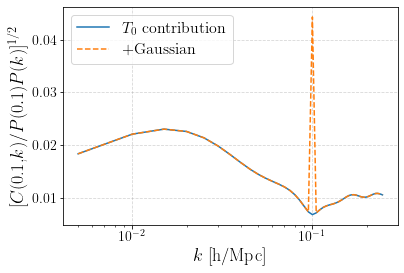

In [14]:
plt.grid(b=True, which='major', color='#999999', linestyle='--',alpha=0.4)
plt.semilogx(k,np.sqrt(plotTrisp))
plt.semilogx(k,np.sqrt(total),ls='dashed')
plt.legend(['$T_0$ contribution','+Gaussian'], loc=2)
plt.xlabel(r"$k$  [h/Mpc]"); plt.ylabel(r"[$C$("+str(round(k[it],2))+",$k)/P("+str(round(k[it],2))+")P(k)]^{1/2}$")
#plt.ylim(1e-5,1e-3)

# Results are in good agreement with Blot et al. 2015

In [19]:
# Uncomment for generating the full covariance matrix

# covMat= np.zeros((len(k),len(k)));
# for i in range(len(k)):
#     covMat[i]=trisp(k[i],k) # Calculating the tree-level trispectrum

# # Adding the Gaussian part
# for i in range(len(k)):
#     covMat[i,i]+=CovGaussian[i]